# This notebook perform an analytical analysis of the LEM-X camera sensitivity with the new mask (1040$\times$17 elements, 0.5 original OF)

In [1]:
%matplotlib ipympl
import numpy as np
import sys

# setting path for mask_utils package
sys.path.append('..')

from mask_utils.code_utils import next_prime, ura_mura
from mask_utils.imaging_utils import decode, decode_var, eff_area_vs_off_axis, snr_vs_off_axis
from mask_utils.imaging_utils import snr_vs_off_axis_eq6
from mask_utils.fits_utils import read_mask_bulk

import matplotlib.pyplot as plt
from matplotlib import cm

## Defining mask file

In [6]:
mask_file = "F:/CodedMasks/mask_050_1040x17/mask_050_1040x17_20251007_ext_diagonal.fits"

## Reading Mask, Bulk and RMATRIX

In [7]:
mask, hdmask = read_mask_bulk(mask_file, 'MASK', header_out=True, verbose=False)
rmatrix = read_mask_bulk(mask_file, 'RMATRIX', header_out=False, verbose=False)
bulk = read_mask_bulk(mask_file, 'SENS', header_out=False, verbose=False)

## Getting mask useful info

In [8]:
#Gets mask information and define X, Y vectors (centers and edges)
ELXDIM = hdmask['ELXDIM']
ELYDIM = hdmask['ELYDIM']
MTHICK = hdmask['MTHICK']
OPENFR=hdmask['OPENFR']
mask_x_pitch = hdmask['DXSLIT']
mask_y_pitch = hdmask['DYSLIT']
det_x_pitch = 0.080

FOCAL = 202.9

## Generating coordinates grid for Effective Area Calculation

In [9]:
thetaX, thetaY  = np.linspace(-45, 45, 46), np.linspace(-45, 45, 46)

## Calculating and plottting Effective Area vs Off-axis angle

In [10]:

eff_area = np.zeros((len(thetaX), len(thetaY)))

for i in range(len(thetaX)):
    for j in range(len(thetaY)):
        eff_area[i, j] = 0.01 * eff_area_vs_off_axis(mask.T.astype('int32'), bulk.T, ELXDIM, ELYDIM, FOCAL, MTHICK, thetaX[i], thetaY[j], degrees=True)

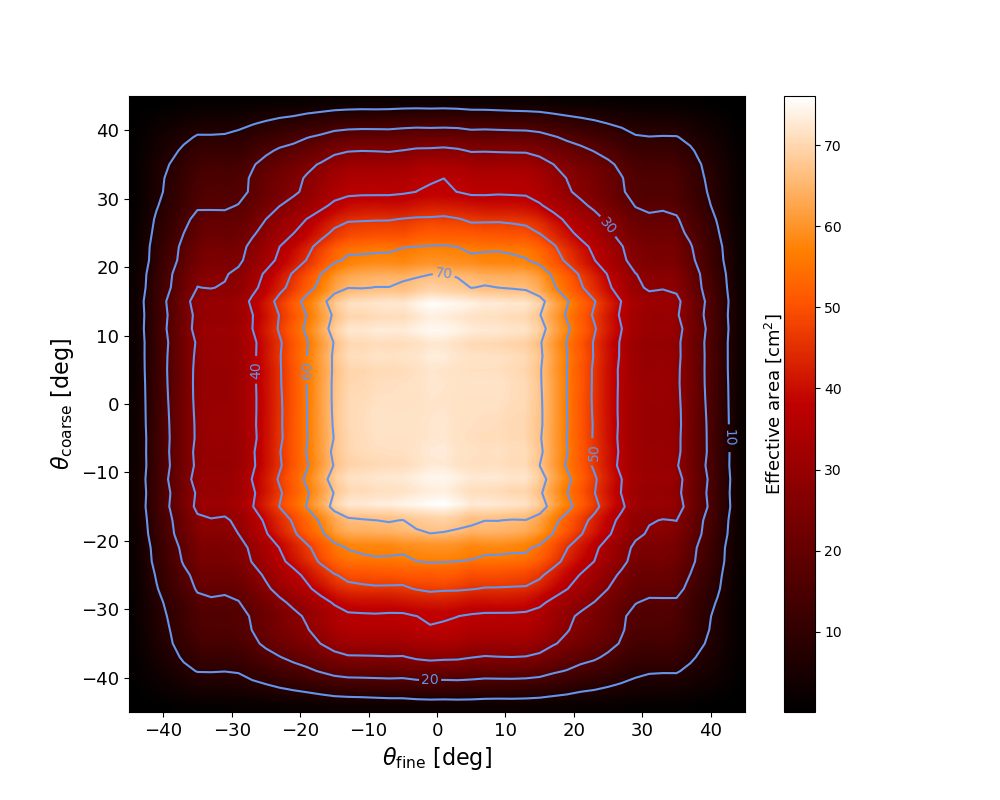

76.09876661685078
[ 0. 10. 20. 30. 40. 50. 60. 70.]


In [11]:
#Factor to consider SDD QE, MLI and filter absorption @ 8keV.
#           dead layer * QE    * 25 um Be * 300nm Al * 12.5um Kapton
qe_factor = 0.974      * 0.999 * 0.99527  * 0.99614  *  0.98945

levels = np.arange(np.max(eff_area)*qe_factor, step=10)
#levels = np.append(levels, [75])
#levels = np.arange(np.max(eff_area)*qe_factor, step=np.max(eff_area)*qe_factor/3)

#levels = np.append(levels, 74)

fig, ax = plt.subplots(1, 1, constrained_layout=False, figsize=(10, 8))
#ax.set_title("Effective area [cm$^2$]")
#im = ax.imshow(eff_area.T * qe_factor, cmap=cm.gist_heat,  interpolation='none', extent=[-45,45,-45,45])
im = ax.imshow(eff_area.T * qe_factor, cmap=cm.gist_heat,  interpolation='bilinear', extent=[-45,45,-45,45])

ax.set_xlabel(r"$\theta_{\mathrm{fine}}$ [deg]", fontsize=16)
ax.set_ylabel(r"$\theta_{\mathrm{coarse}}$ [deg]", fontsize=16)

ax.xaxis.set_tick_params(labelsize=13)
ax.yaxis.set_tick_params(labelsize=13)

cs = ax.contour(eff_area.T, levels, extent=[-45,45,-45,45], colors='cornflowerblue')
ax.clabel(cs, cs.levels, fontsize=10)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Effective area [cm$^2$]', rotation=90, labelpad=-57, y=0.5, fontsize=13)

plt.savefig("LEM-X_camera_effectiva_area_ext_diagonal.pdf", format="pdf", bbox_inches="tight")

plt.show()

print(np.max(eff_area)*qe_factor)
print(levels)

## Now we calculate system Sensitivity vs Off-axis angle using Crab and CXB count rates from FC simulations
### Sim file is crab_cxb_2-50keV_1ks_mask_050_1040x17_cam1a_detected.fits


In [12]:
area_ratio_map = eff_area/np.max(eff_area)

In [13]:
s_counts = 2.5737 #source counts (per unit area) when the mask is open
b_counts = 6.3799 #bkg counts per detector unit area

eff_area_onaxis = 0.01 * eff_area_vs_off_axis(mask.T.astype('int32'), bulk.T, ELXDIM, ELYDIM, FOCAL, MTHICK, 0, 0, degrees=True) * qe_factor

print("Total source couts/s:", s_counts * np.max(eff_area_onaxis))
print("Total background couts/s:",b_counts * np.max(eff_area_onaxis))


##########################################################################
# IN THE FOLLOWING I CONSIDER A CPOWER=0.85 (rec/det) AS ESTIMATED BY SIMS
##########################################################################


sens_map = np.zeros((len(thetaX), len(thetaY)))

# IMPORTANT !!!!!!
# Added (1-area_ratio_map[i,j]) * s_counts to the b_counts to correct for sensitivity overestimation

for i in range(len(thetaX)):
    for j in range(len(thetaY)):
        sens_map[i, j] = 1000 / (snr_vs_off_axis(s_counts, b_counts + (1-area_ratio_map[i,j]) * s_counts, mask, bulk,
                                mask_x_pitch, mask_y_pitch,
                                ELXDIM, ELYDIM, det_x_pitch,
                                FOCAL, MTHICK, thetaX[i], thetaY[j], degrees=True, cpower_detres = 0.85)/5)


Total source couts/s: 182.84909962441606
Total background couts/s: 453.26144099693516


<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Utente\AppData\Local\Temp\ipykernel_23432\2604518380.py:18: SyntaxWarning: invalid escape sequence '\s'
  cbar.set_label('Sensitivity 5$\sigma$ 1s [mCrab]', rotation=90, labelpad=-70, y=0.5, fontsize=13)


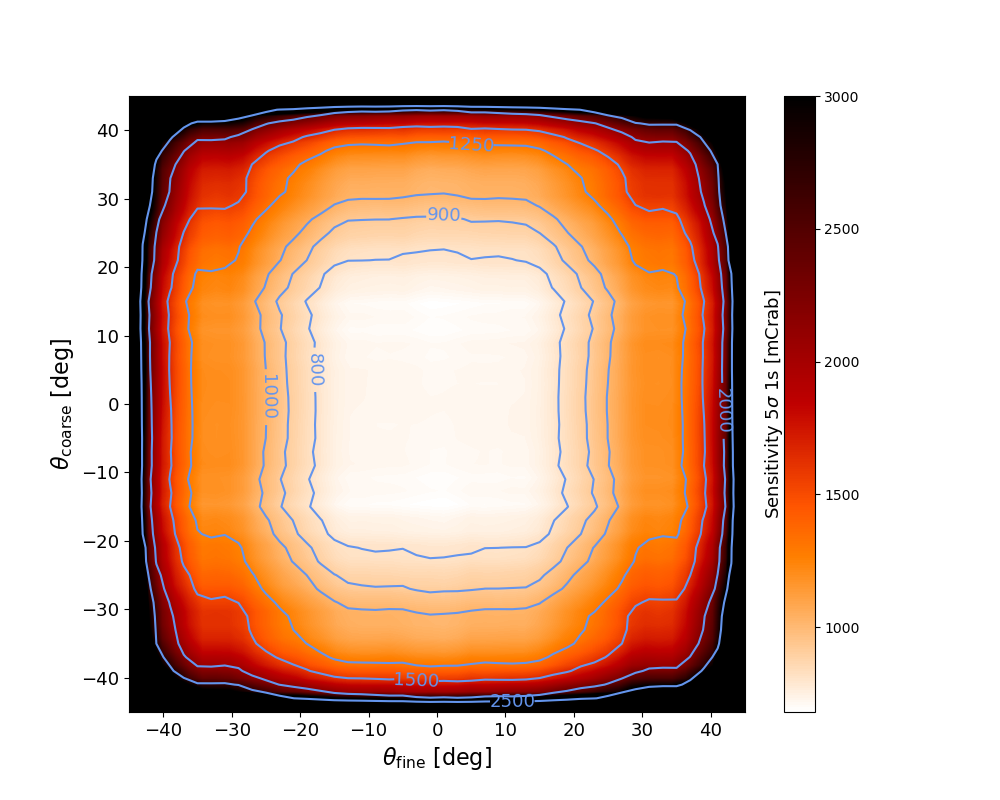

In [14]:


levels = np.arange(800, np.max(sens_map), step=200)
#levels = np.append(levels, 74)
levels = [800, 900, 1000, 1250, 1500, 2000, 2500]

fig, ax = plt.subplots(1, 1, constrained_layout=False, figsize=(10, 8))
#ax.set_title(r"Sensitivity 5$\sigma$ 1s [mCrab]")
im = ax.imshow(sens_map.T, cmap=cm.gist_heat_r, vmax=3000,  interpolation='bilinear', extent=[-45,45,-45,45])

ax.xaxis.set_tick_params(labelsize=13)
ax.yaxis.set_tick_params(labelsize=13)


ax.set_xlabel(r"$\theta_{\mathrm{fine}}$ [deg]", fontsize=16)
ax.set_ylabel(r"$\theta_{\mathrm{coarse}}$ [deg]", fontsize=16)
cs = ax.contour(sens_map.T, levels, extent=[-45,45,-45,45], colors='cornflowerblue')
ax.clabel(cs, cs.levels, fontsize=13)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Sensitivity 5$\sigma$ 1s [mCrab]', rotation=90, labelpad=-70, y=0.5, fontsize=13)

plt.savefig("LEM-X_camera_sensitivity_mod_ext_diagonal.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [15]:
from mask_utils.imaging_utils import decode, decode_var, eff_area_vs_off_axis, snr_vs_off_axis

#Printing expected SNR for a Crab on-axis
on_axis_sens = 1000 / (snr_vs_off_axis(s_counts, b_counts, mask, bulk,
                                mask_x_pitch, mask_y_pitch,
                                ELXDIM, ELYDIM, det_x_pitch,
                                FOCAL, MTHICK, 0, 0, degrees=True, cpower_detres=0.85)/5)

sens = 1000 / (snr_vs_off_axis(s_counts, b_counts + s_counts * 0.594  , mask, bulk,
                                mask_x_pitch, mask_y_pitch,
                                ELXDIM, ELYDIM, det_x_pitch,
                                FOCAL, MTHICK, -30, 0, degrees=True, cpower_detres=0.85)/5)

sens_eq6 = 1000 / (snr_vs_off_axis_eq6(s_counts, b_counts , mask, bulk,
                                mask_x_pitch, mask_y_pitch,
                                ELXDIM, ELYDIM, det_x_pitch,
                                FOCAL, MTHICK, -30, 0, degrees=True, cpower_detres=0.85)/5)



print("Expected on-axis Crab significance in 1ks:", int(1000/on_axis_sens * 5 * np.sqrt(1000)))
print("Expected  Crab significance in 1ks:", int(1000/sens * 5 * np.sqrt(1000)))

print("Expected  Crab significance in 1ks (eq6):", int(1000/sens_eq6 * 5 * np.sqrt(1000)))


Expected on-axis Crab significance in 1ks: 220
Expected  Crab significance in 1ks: 131
Expected  Crab significance in 1ks (eq6): 142


## Eventually we test the analytic formula against a dummy simulation considering the Crab and Bkg counts in 1ks

### Generating dummy source and flat bkg using FC countrates

In [12]:
#Test significance with flat bkg
detimage_src = np.random.poisson(lam=196691/np.sum(mask * bulk), size=mask.shape) * mask * bulk
detimage_bkg = np.random.poisson(lam=487584/np.sum(bulk), size=mask.shape) * bulk
print(np.sum(detimage_src), np.sum(detimage_bkg))

detimage = detimage_src + detimage_bkg

196837.0 488344.0


### Decoding sky image

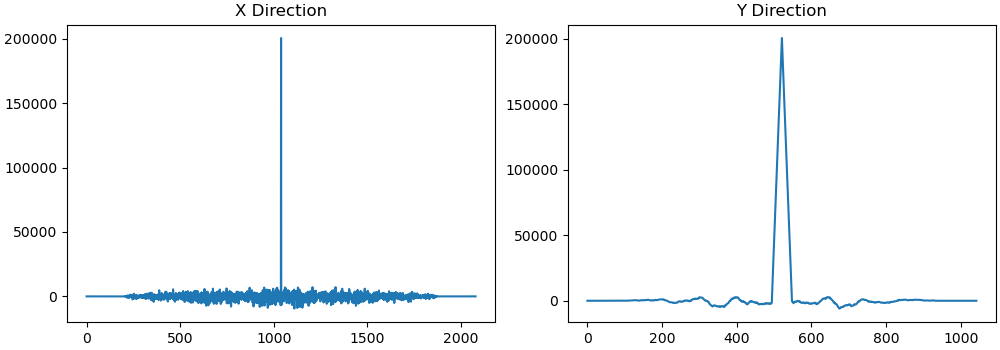

In [13]:
sky = decode(detimage, rmatrix, bulk)
peak_p = np.unravel_index(np.argmax(sky), sky.shape)

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3.5))
axs[0].set_title('X Direction')
axs[0].plot(sky[:, peak_p[1]])
axs[1].set_title('Y Direction')
axs[1].plot(sky[peak_p[0], :])
plt.show()


### Generating and plotting significance image

Peak significance: 261.729156228294


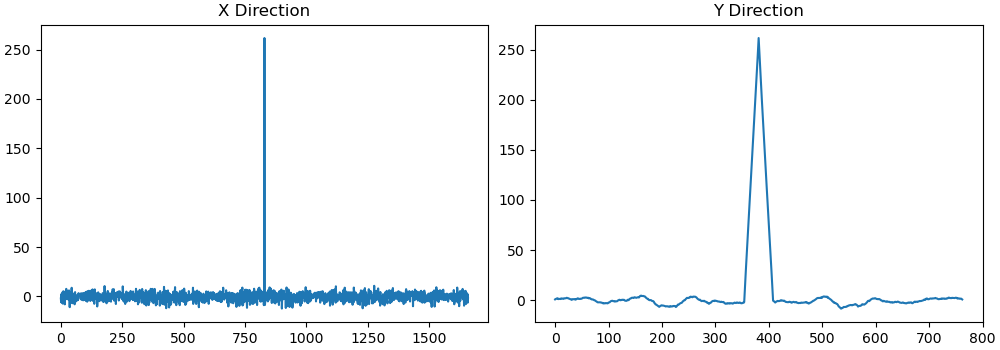

In [14]:
var_bal = decode_var(detimage, rmatrix, bulk, 202.9, ELXDIM, ELYDIM)
var_bal_clipped =  np.clip(var_bal, a_min=1E-8, a_max=np.sum(detimage)*10) if np.any(var_bal <= 0) else var_bal

skysign = sky/np.sqrt(var_bal_clipped)

# Filtering borders...
skysign_cut = skysign[210:-210, 140:-140 ]

peak_s = np.unravel_index(np.argmax(skysign_cut), skysign_cut.shape)
print("Peak significance:", np.max(skysign_cut))

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3.5))
axs[0].set_title('X Direction')
axs[0].plot(skysign_cut[:, peak_s[1]])
axs[1].set_title('Y Direction')
axs[1].plot(skysign_cut[peak_s[0], :])
plt.show()

## Analytical formula and dummy simulation seems to be in a very good agreement!
Comparison with FC simulation shows that a non flat Background causes a slight reduction in peak sensitivity
which is $\sim$255$\sigma$ instead of the 262$\sigma$ analytically predicted

In [16]:
eff_area_on_axis = 0.01 * eff_area_vs_off_axis(mask.T.astype('int32'), bulk.T, ELXDIM, ELYDIM, FOCAL, MTHICK, 0, 0, degrees=True)
eff_area_off_axis = 0.01 * eff_area_vs_off_axis(mask.T.astype('int32'), bulk.T, ELXDIM, ELYDIM, FOCAL, MTHICK, -30, 0, degrees=True)
print(1-(eff_area_off_axis/eff_area_on_axis))

0.5937133403055042
